# Processing Sentinel 5P netCDF data

In [3]:
import arcgis
from arcgis.gis import GIS
from arcgis.features.analysis import interpolate_points
import arcpy
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import os
import pathlib

In [4]:
gis = GIS('home')

In [5]:
# nc_folder = r'E:\GIS_Data\Imagery\sentinel-5p\lax-nrt'
nc_folder = r'/arcgis/home/no2'
nc_file = 'la__20200513.nc'
la_aoi = os.path.join(nc_folder,'la_aoi','la_aoi.shp')
nc_path = os.path.join(nc_folder, nc_file)
print(nc_path)

/arcgis/home/no2/la__20200513.nc


## Methodology

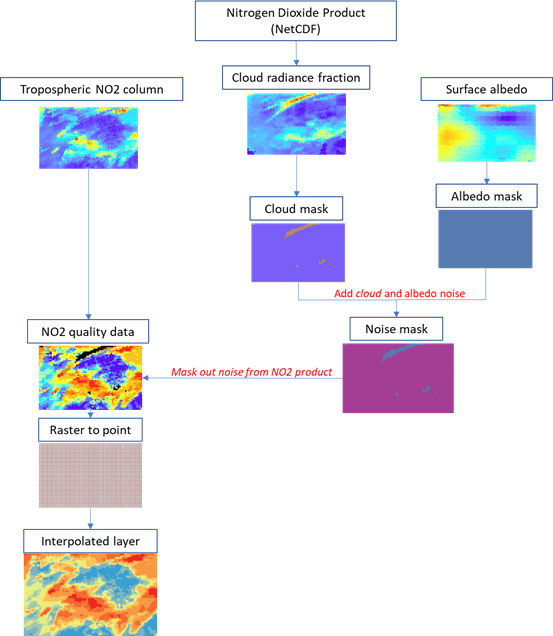

## Read netCDF into multidimensional raster

In [3]:
# Read NO2 variable
no2_mdim_result = arcpy.md.MakeMultidimensionalRasterLayer(nc_path, 
                                                    os.path.join(nc_folder, 'no2_arcpy.tif'), 
                                                    "/PRODUCT/nitrogendioxide_tropospheric_column", 
                                                    "ALL", None, None, '', '', '', None, '', 
                                                    "DEFAULT", "DIMENSIONS")

In [52]:
# Read cloud fraction variable
cfrac_mdim_result = arcpy.md.MakeMultidimensionalRasterLayer(nc_path, 
                                                    os.path.join(nc_folder, 'cfrac_arcpy.tif'), 
                                                    "/PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_fraction_crb", 
                                                    "ALL", None, None, '', '', '', None, '', 
                                                    "DEFAULT", "DIMENSIONS")

In [12]:
# read surface albedo result
salbedo_mdim_result = arcpy.md.MakeMultidimensionalRasterLayer(nc_path, 
                                                    os.path.join(nc_folder, 'salbedo_arcpy.tif'), 
                                                    "/PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_albedo_nitrogendioxide_window", 
                                                    "ALL", None, None, '', '', '', None, '', 
                                                    "DEFAULT", "DIMENSIONS")

In [6]:
mkdir /arcgis/home/no2/output

In [105]:
# read into ArcGIS Raster objects
_no2_layer = no2_mdim_result.getOutput(0)
_cfrac_layer = cfrac_mdim_result.getOutput(0)
_salbedo_layer = salbedo_mdim_result.getOutput(0)

_no2_ras = arcpy.ia.Raster(_no2_layer.name)
_cfrac_ras = arcpy.ia.Raster(_cfrac_layer.name)
_salbedo_ras = arcpy.ia.Raster(_salbedo_layer.name)

no2_ras = arcgis.raster.Raster(_no2_ras)
cfrac_ras = arcgis.raster.Raster(_cfrac_ras)
salbedo_ras = arcgis.raster.Raster(_salbedo_ras)

## Visualize local & in-memory raster layers 

In [44]:
map1 = gis.map('USA')
map1

MapView(layout=Layout(height='400px', width='100%'))

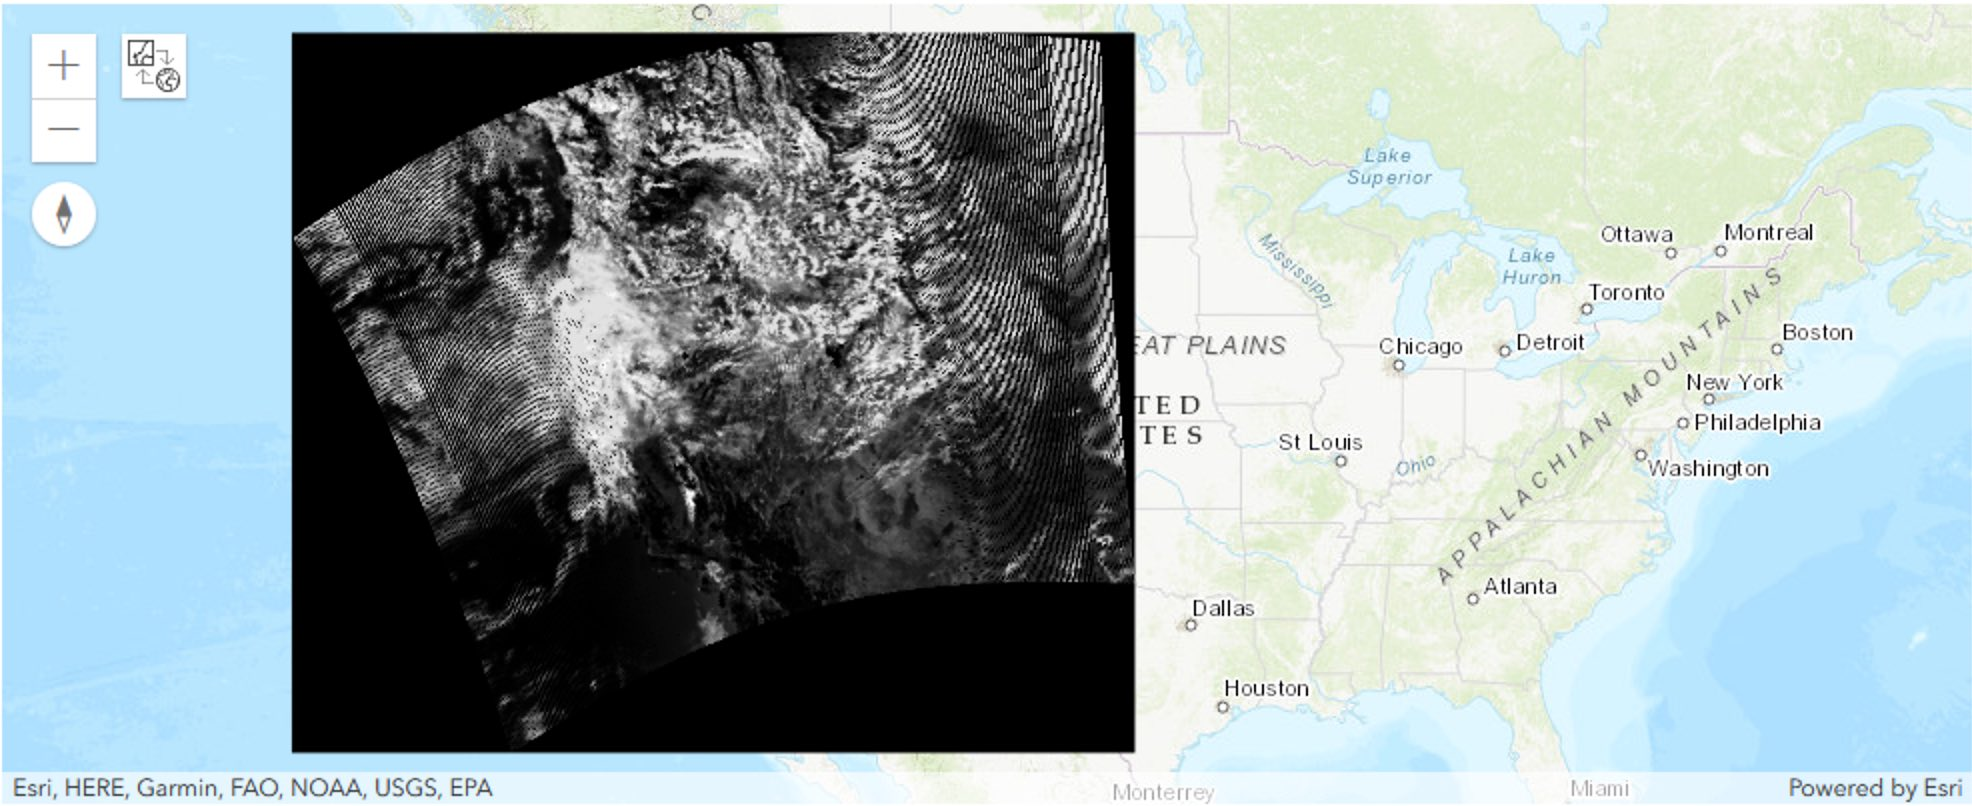

In [104]:
# visualize cloud fraction raster
map1.add_layer(cfrac_ras)

## Self correct for atmospheric influence

In [106]:
from arcgis.raster.functions import stretch
from arcgis.raster.functions import less_than, threshold, is_null, con
from arcgis.raster import analytics
from arcpy.sa import RescaleByFunction

Since, weather is a dynamic phenomenon and it affects the quality of data. To remove the noise from the data, clouds and surface albedo were removed. The [Sentinel-5P Level-2 manual](https://sentinel.esa.int/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Nitrogen-Dioxide) specifies QA threshold value for both "surface_albedo" and "cloud_radiance_fraction".

#### Create cloud mask<a class="anchor" id="11"></a>

QA threshold for "cloud_radiance_fraction" < 0.5.

In [110]:
cloud_filter = less_than([cfrac_ras, 0.5], extent_type='FirstOf', 
                         cellsize_type='FirstOf',astype='F32')

#### Create surface albedo mask<a class="anchor" id="12"></a>

QA threshold for "surface_albedo" < 0.3.

In [59]:
albedo_filter = less_than([salbedo_ras, 0.3], extent_type='FirstOf', 
                          cellsize_type='FirstOf', astype='F32')

#### Filter out bad cells

To extract the good quality NO2 pixels, first both cloud and surface albedo masks were added to get the noise mask. The values of "Noise mask" ranges from 1-2.

[threshold](https://pro.arcgis.com/en/pro-app/help/data/imagery/binary-thresholding-function.htm) function was used to convert the range of "Noise mask" from 1-2 to 0-1.

[is_null](https://pro.arcgis.com/en/pro-app/help/data/imagery/is-null-function.htm) function was used to create "False raster" which has 1 value where input value is NoData and 0 where data is present.

[Con](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/con-.htm) function was used to mask out the noise and get good quality data. 
* "threshold_raster" was taken as `in_conditional_raster` which represents the true or false result of the desired condition.
* "no2_layer" was taken as `in_true_raster_or_constant` whose value will be used as the output cell value if the condition is true.
* "null_raster" was specified as `in_false_raster_or_constant` whose value will be considered as the output cell values if the condition is false.

The output raster of `Con` function only has good quality pixels.

In [50]:
# create a mask layer
binary_r = cloud_filter + albedo_filter

# make a boolean raster to use a condition check - produced by reducing cloud and albedo filters
condition_r = threshold(binary_r, astype='F32')

# make null raster
null_r = is_null([condition_r], cellsize_type='MaxOf', astype='F32')

# check for valid cells
no2_checked = con([condition_r, no2_ras, null_r], extent_type='FirstOf',
                 cellsize_type='FirstOf', astype='F32')

### Visualize corrected $NO_{2}$ raster

In [72]:
map2 = gis.map('USA')
map2

MapView(layout=Layout(height='400px', width='100%'))

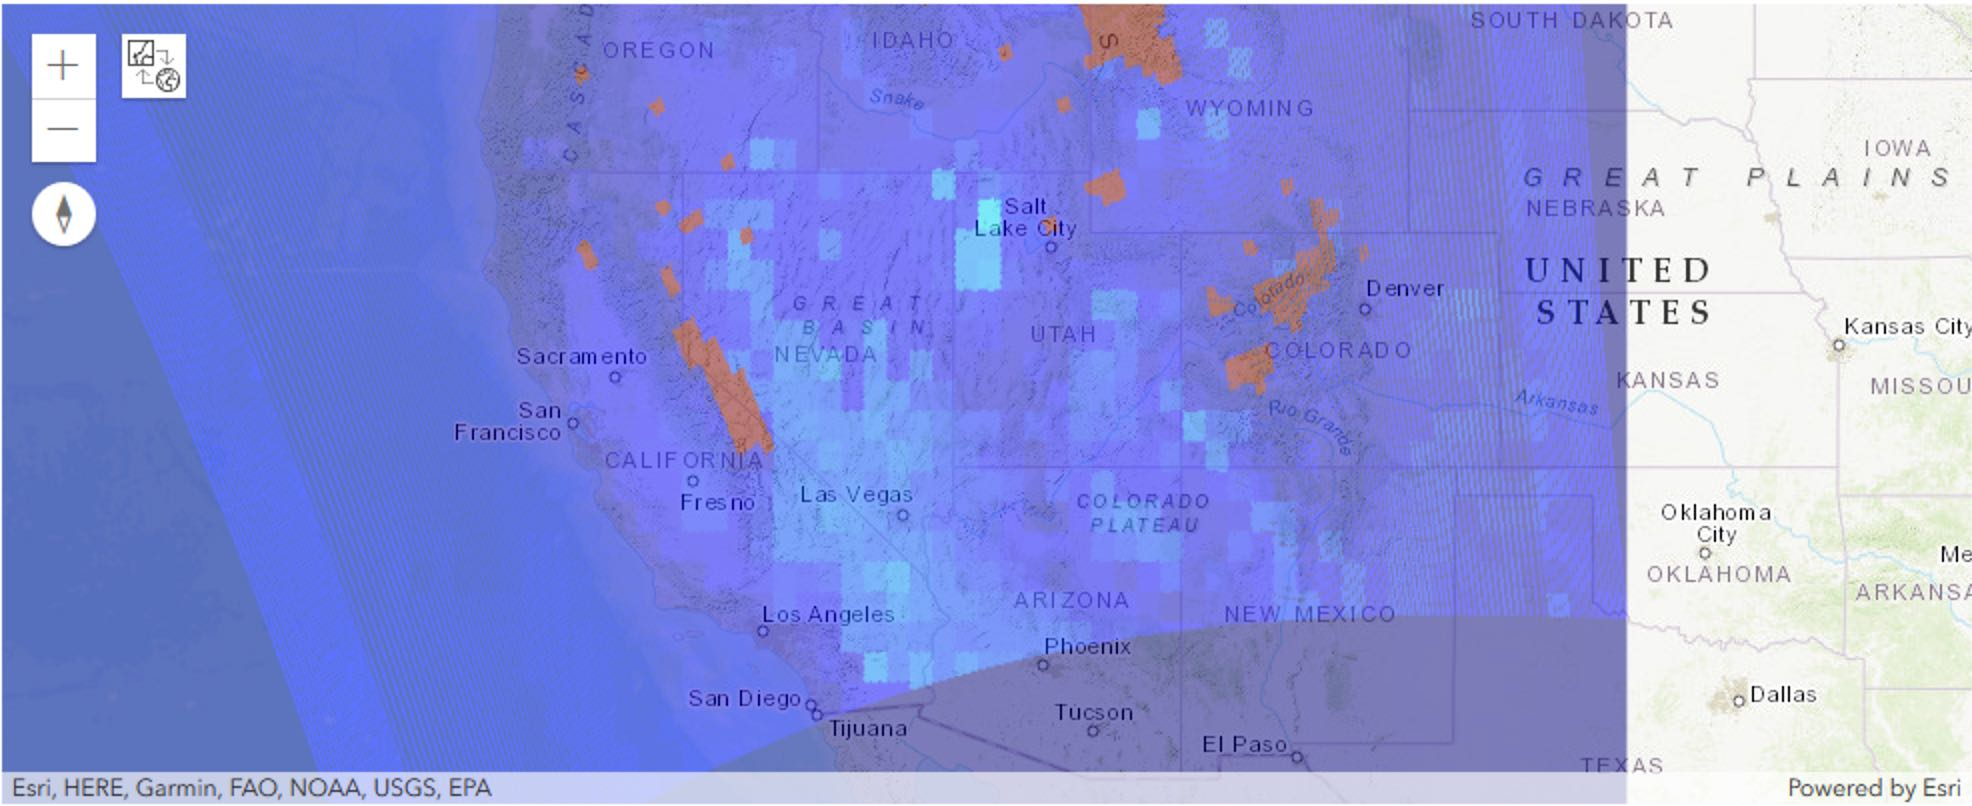

In [73]:
no2_checked.cmap = "jet"
no2_checked.opacity = 0.5

map2.add_layer(no2_checked)

### Convert to raster to points

In [164]:
arcpy.env.overwriteOutput = True
arcpy.ia.Raster(no2_ras._engine_obj.url).save(os.path.join(nc_folder, 'output','no2_corrected2.tif'))

In [171]:
arcpy.management.Clip(os.path.join(nc_folder, 'output','no2_corrected2.tif'), 
                      rectangle="-119.21831392892 32.5456262890642 -115.10387716824 34.5099528594319",
                      out_raster= os.path.join(nc_folder, 'output','no2_clipped.tif'))

no2_clipped_aras = arcpy.ia.Raster(os.path.join(nc_folder, 'output','no2_clipped.tif'))

In [172]:
no2_pts = os.path.join(nc_folder, 'output','no2_pts2.shp')
arcpy.conversion.RasterToPoint(no2_clipped_aras, no2_pts)

<Result 'Y:\\Documents\\GIS_data\\Imagery\\sentinel-5p\\lax_nrt\\output\\no2_pts2.shp'>

In [173]:
no2_pts_sdf = pd.DataFrame.spatial.from_featureclass(no2_pts)
no2_pts_sdf.head()

,FID,pointid,grid_code,SHAPE
0,0,1,0.000037,"{""x"": -119.23090934753418, ""y"": 34.51227378845..."
1,1,2,0.000027,"{""x"": -119.19385719299316, ""y"": 34.51227378845..."
2,2,3,0.000028,"{""x"": -119.15680503845215, ""y"": 34.51227378845..."
3,3,4,0.000028,"{""x"": -119.11975288391113, ""y"": 34.51227378845..."
4,4,5,0.000031,"{""x"": -119.08270072937012, ""y"": 34.51227378845..."


In [174]:
no2_pts_sdf.shape

(6048, 4)

Publish the points as a web layer

In [175]:
no2_pts_item = no2_pts_sdf.spatial.to_featurelayer('NO2 conc as points')

In [180]:
t = datetime.now().strftime('%y%m%d_%H%M%S')
t

'200521_181248'

### Interpolate for missing data using EBK

In [181]:
no2_interp_item = interpolate_points(no2_pts_item.layers[0],
                              "grid_code", 
                              interpolate_option='5', 
                              classification_type='Manual',
                              num_classes=8,
                              class_breaks=[0.000030,0.000042,0.000053,0.000067,0.000087,0.000125,0.000192,0.0007],
                              output_name="no2_intrp_"+t)

In [182]:
map3 = gis.map('Los Angeles')
map3

MapView(layout=Layout(height='400px', width='100%'))

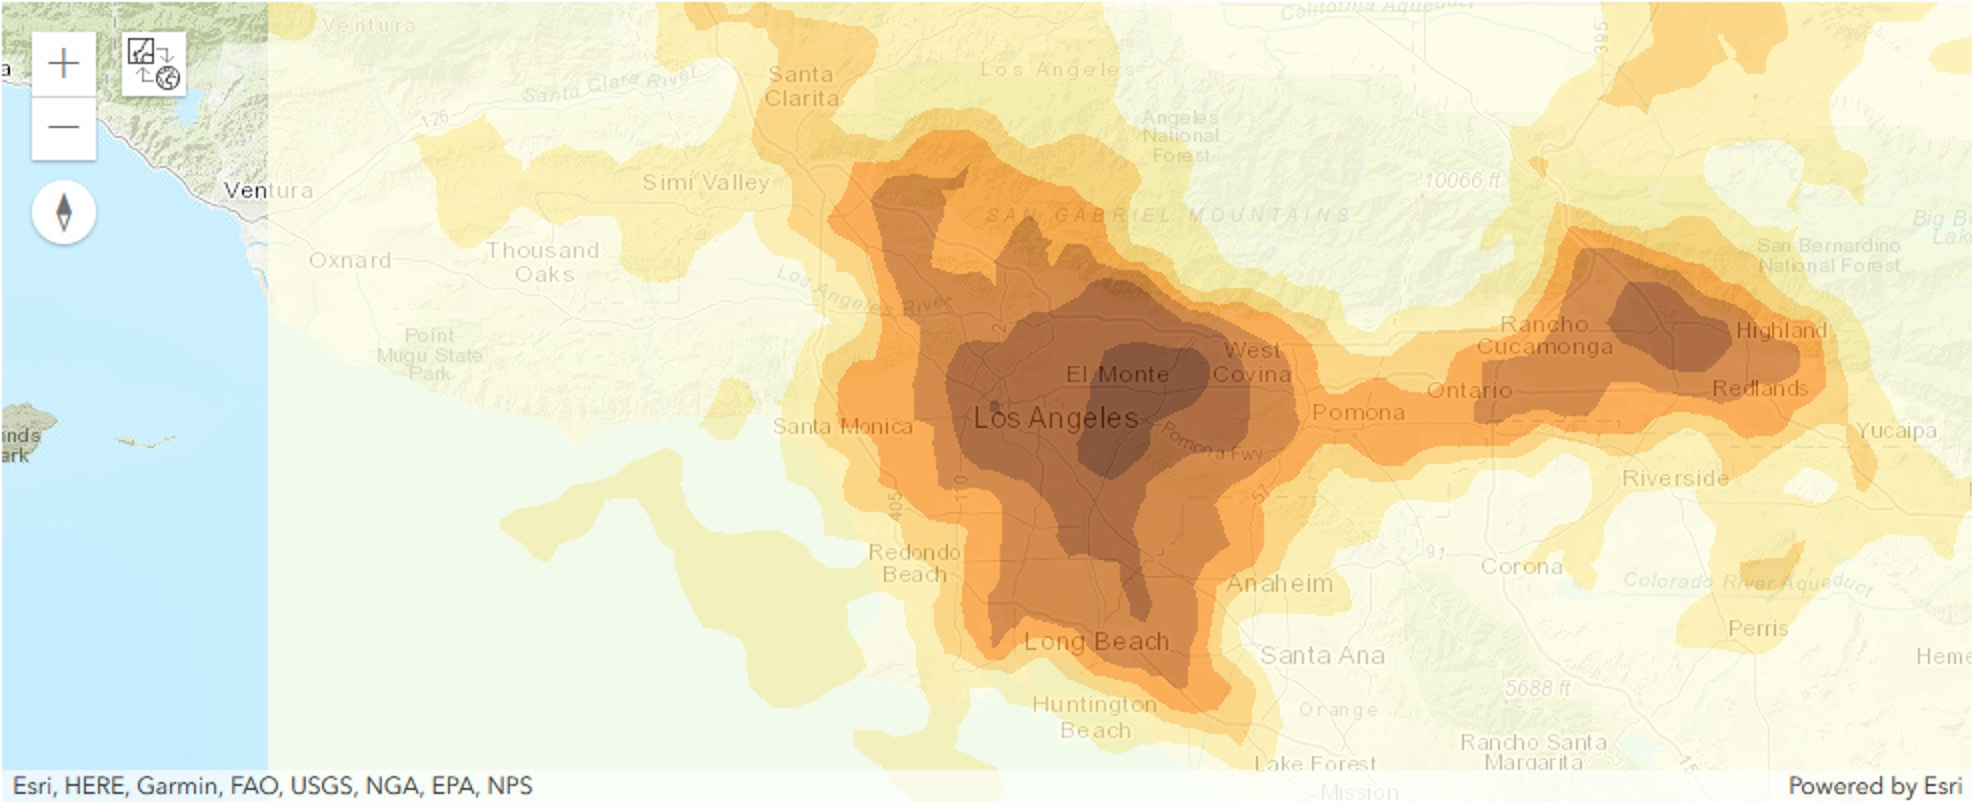

In [183]:
map3.add_layer(no2_interp_item)

## Conclusion<a class="anchor" id="18"></a>

Wuhan is one of the most populous city of China which is related high economic growth, industries, large number of vehicles, etc. With urbanisation and industrial growth pollution also increases, suggesting high concentration of NO2. To control the spread COVID-19 Epidemic the city was locked down and all the industries, vehicles and other sources of NO2 emission were stopped. Due to which the NO2 levels in the atmosphere also decreases after lockdown over Wuhan. Sentinel-5P NO2 data product was used for studying the spatial variations of NO2 concentration in atmosphere over time. The results of the study suggests that the NO2 concentration over Wuhan was decreased after the COVID-19 lockdown. The same methodology can be used to study the NO2 concentration for different regions with Sentinel-5P NO2 data product using ArcGIS platform.  

## Data Resources<a class="anchor" id="19"></a>

| Data and literature | Source | Link |
| -| - |-|
| Sentinel-5P NO2 Product|          Sentinel-5P Pre-Operations Data Hub | https://s5phub.copernicus.eu/dhus/#/home| 
|User Manual|                       Sentinel-5P Level 2 User Manual        | https://sentinel.esa.int/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Nitrogen-Dioxide|
| Research Paper|                   Spatial Variation of NO2 and Its Impact Factors in China: An Application of Sentinel-5P Products           | https://www.researchgate.net/publication/335249253_Spatial_Variation_of_NO2_and_Its_Impact_Factors_in_China_An_Application_of_Sentinel-5P_Products|
| Research Paper|                   Spaceborne Nitrogen Dioxide Observations from the Sentinel-5P TROPOMI over Turkey           |   https://www.mdpi.com/2504-3900/18/1/4/pdf|